<a href="https://colab.research.google.com/github/diegohugo570/backup-python/blob/main/03_Criando_seus_primeiros_agentic_workflows_%7C_Curso_de_LangGraph_DascIA_Academy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construindo um Grafo Simples

<img src="https://i.ibb.co/PZ0WpPtB/Lead-Entra-na-Lista-33.png" width=700px>

Neste notebook, você vai construir os seus primeiros fluxos de trabalho agêntico com o LangGraph. Mas antes de começar, vamos recapitular três conceitos que já estudamos anteriormente, mas agora falando no contexto do langgraph:
- **Estado**
- **Nós**
- **Arestas** ***(condicionais)***

---

## Estado do Grafo

Todo grafo no LangGraph começa com a definição de um **estado** — um dicionário que trafega entre os nós e pode ser lido ou alterado. Vamos usar o `TypedDict` para tipar esse estado:

In [ ]:
# Importando a biblioteca
from typing_extensions import TypedDict, Annotated
from typing import List

# Definindo o estado do grafo
class State(TypedDict):
  graph_state: str

## Nós

Cada **nó** do grafo é uma função Python que recebe o estado e retorna um novo estado.

```python
def meu_no(state: State) -> State:
    return {"graph_state": novo_valor}
```

O novo valor sobrescreve o valor anterior da chave `graph_state`.

In [ ]:
# Definindo os nós
def node_inicio(state: State) -> State:
  print("-=-=- Node 1 -=-=-")
  return {"graph_state": state["graph_state"] + "Eu torço para  "}

def node_final1(state: State) -> State:
  print("-=-=- Node 2 -=-=-")
  return {"graph_state": state["graph_state"] + "Palmeiras"}

def node_final2(state: State) -> State:
  print("-=-=- Node 3 -=-=-")
  return {"graph_state": state["graph_state"] + "Flamengo"}

## Aresta Condicional

Agora vamos criar uma **aresta condicional**, que decide entre dois caminhos possíveis com base no estado (ou aleatoriamente neste caso):

In [ ]:
# Definindo uma aresta condicional
from typing import Literal
import random

def node_decididor(state: State) -> Literal["node_final1", "node_final2"]:
  valor = random.random()
  if valor > 0.5:
    return "node_final1"
  else:
    return "node_final2"

## Montagem do Grafo

Usamos o `StateGraph` para construir nosso grafo. Os nós e arestas são adicionados e, por fim, o grafo é compilado.

Também usamos os nós especiais:
- `START`: início do grafo
- `END`: final do grafo

In [ ]:
!pip install -qU langgraph

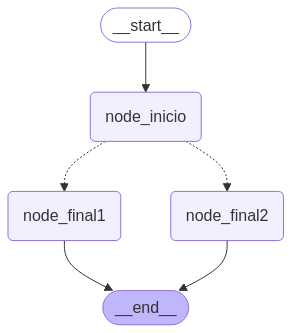

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Adicionando os nós
builder = StateGraph(State)
builder.add_node("node_inicio", node_inicio)
builder.add_node("node_final1", node_final1)
builder.add_node("node_final2", node_final2)

# Adicionando as arestas
builder.add_edge(START, "node_inicio")
builder.add_conditional_edges("node_inicio", node_decididor)
builder.add_edge("node_final1", END)
builder.add_edge("node_final2", END)

# Compilando o grafo
graph = builder.compile()

# Visualização
display(Image(graph.get_graph().draw_mermaid_png()))

## Execução do Grafo

Vamos invocar o grafo com um estado inicial. O grafo será executado de forma síncrona até o nó `END`, e cada etapa irá modificar o estado com base nas funções dos nós.

In [ ]:
# Invocando o grafo com um estado inicial
graph.invoke({"graph_state": "Olá, aqui é o Anwar. "})

-=-=- Node 1 -=-=-
-=-=- Node 2 -=-=-


{'graph_state': 'Olá, aqui é o Anwar. Eu torço para  Palmeiras'}

✅ O resultado será algo como:

```python
{'graph_state': 'Olá, aqui é o Anwar. Eu torço para o Palmeiras'}
```

ou

```python
{'graph_state': 'Olá, aqui é o Anwar. Eu torço para o Flamengo'}
```

A transição entre `node_final1` e `node_final2` depende da função `node_decididor`, que aqui foi implementada de forma aleatória (50/50).

Nos próximos notebooks, vamos explorar como usar o estado de forma mais inteligente para tomar decisões condicionais baseadas em lógica real.

# Encadeamento com Estado e Ferramentas

Agora que já vimos como criar um grafo simples no Langgraph, vamos adicionar um pouco mais de complexidades, como **execução de modelos de linguagem** nos nós, **tool calling** e combinar tudo isso.

- Uso de mensagens como estado do grafo
- Execução de modelos de linguagem (LLMs) em nós
- Uso de ferramentas externas (tool calling)
- Combinação de tudo em um grafo executável

---

## Criando uma Conversa com Mensagens

Vamos simular uma conversa entre o modelo e o usuário.

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Então você disse que é um artista?", name="IA")]
messages.append(HumanMessage(content="Sim, exatamente.", name="Anwar"))
messages.append(AIMessage(content="Ótimo, o que você gostaria de saber?", name="IA"))
messages.append(HumanMessage(content="Quero saber qual a melhor cidade dos EUA para fazer um show de rock.", name="Anwar"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: IA

Então você disse que é um artista?
================================ Human Message =================================
Name: Anwar

Sim, exatamente.
================================== Ai Message ==================================
Name: IA

Ótimo, o que você gostaria de saber?
================================ Human Message =================================
Name: Anwar

Quero saber qual a melhor cidade dos EUA para fazer um show de rock.


## Carregando o Modelo de Chat

Vamos usar o `gpt-4o-mini`, que tem bom desempenho, tem um bom custo e suporte a ferramentas.

In [ ]:
# Instalação das bibliotecas
!pip install -qU langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00


In [ ]:
# Definindo as variáveis de ambiente
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_env("OPENAI_API_KEY")

In [ ]:
# Instanciando o modelo
llm = ChatOpenAI(model="gpt-4o-mini")

# Obtendo o resultado
result = llm.invoke(messages)
result.pretty_print()

================================== Ai Message ==================================

Existem várias cidades nos Estados Unidos que são conhecidas por sua cena de rock vibrante. Aqui estão algumas das melhores opções:

1. **Los Angeles, Califórnia** - Com uma rica história no rock e várias casas de shows icônicas, como o Whisky a Go Go e o Troubadour, LA é um destino popular para bandas de rock.

2. **Nova York, Nova York** - A cidade tem uma cena musical diversificada e repleta de locais históricos, como o CBGB e o Bowery Ballroom.

3. **Seattle, Washington** - Conhecida como o berço do grunge, Seattle tem uma rica tradição no rock e várias casas de shows interessantes.

4. **Austin, Texas** - Famosa por seu festival South by Southwest (SXSW) e uma cena musical ao vivo vibrante, Austin é uma ótima cidade para shows de rock.

5. **Nashville, Tennessee** - Embora seja conhecida principalmente pela música country, Nashville tem uma cena de rock crescente e muitos locais de performance.

6. *

## Adicionando uma Ferramenta (Tool)

Vamos permitir que o modelo execute uma função Python como ferramenta:

In [ ]:
def multiplicar(a: int, b: int) -> int:
    """
    Multiplica dois números inteiros.

    Args:
        a (int): O primeiro número.
        b (int): O segundo número.

    Returns:
        int: O resultado da multiplicação.
    """
    return a * b

llm_com_ferramenta = llm.bind_tools([multiplicar])

# Testando o uso da ferramenta
resposta = llm_com_ferramenta.invoke([HumanMessage(content="Quanto é 10 vezes 3?", name="Anwar")])
resposta

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CdLOmzMNy7wkJ1wzMkqIBkUx', 'function': {'arguments': '{"a":10,"b":3}', 'name': 'multiplicar'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 68, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BHHe9Aw6OrK4zFRw3omqz3N9u9yLd', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e1c85e87-a177-4797-80b3-6b65ad947fb7-0', tool_calls=[{'name': 'multiplicar', 'args': {'a': 10, 'b': 3}, 'id': 'call_CdLOmzMNy7wkJ1wzMkqIBkUx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 68, 'output_tokens': 20, 'total_tokens': 88, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

In [ ]:
resposta.tool_calls

[{'name': 'multiplicar',
  'args': {'a': 10, 'b': 3},
  'id': 'call_CdLOmzMNy7wkJ1wzMkqIBkUx',
  'type': 'tool_call'}]

## Usando mensagens como estado

Vamos definir o estado como uma lista de mensagens. O LangGraph já tem um tipo pronto para isso: `MessagesState`.

Também usaremos um **reducer** chamado `add_messages` para **acumular** mensagens em vez de sobrescrevê-las.

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langchain_core.messages import AnyMessage

# Definindo o estado do grafo conversacional
class MessagesState(TypedDict):
  messages: List[AnyMessage]

## Construindo o Grafo com Modelo + Tool

Vamos construir um grafo com apenas um nó:
- Ele recebe mensagens
- Invoca o modelo com ferramenta
- Retorna a nova mensagem para o estado

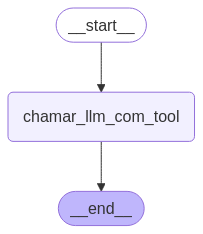

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Nó que executa o LLM com ferramenta
def chamar_llm_com_tool(state: MessagesState):
    return {"messages": [llm_com_ferramenta.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("chamar_llm_com_tool", chamar_llm_com_tool)

builder.add_edge(START, "chamar_llm_com_tool")
builder.add_edge("chamar_llm_com_tool", END)

graph = builder.compile()

# Visualização
display(Image(graph.get_graph().draw_mermaid_png()))

## Executando o Grafo

Vamos testar com duas entradas:
1. Saudação simples
2. Requisição que exige o uso da ferramenta

In [ ]:
mensagens = graph.invoke({"messages": [HumanMessage(content="Olá! Tudo bem?", name = "Anwar")]})
for m in mensagens['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Olá, Anwar! Estou bem, obrigado. E você, como está?


In [ ]:
mensagens = graph.invoke({"messages": [HumanMessage(content="Multiplica 2 por 3", name = "Anwar")]})
for m in mensagens['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiplicar (call_SLTxmgVOa0oEF5MnyDPEsLxW)
 Call ID: call_SLTxmgVOa0oEF5MnyDPEsLxW
  Args:
    a: 2
    b: 3


✅ Agora você tem um grafo funcional com:
- Estado baseado em mensagens
- Modelo de linguagem que responde com ou sem ferramenta
- Uso do reducer `add_messages` para manter histórico da conversa

Nos próximos módulos, vamos expandir com múltiplos nós, lógica condicional e agentes independentes.